# Forecasting 2030 Barangay Populations in Iligan City

This notebook presents a scientific approach to forecasting the 2030 population of each barangay in Iligan City using historical data from 1990 to 2020. We apply multiple forecasting models and select the best-fitting one per barangay using RMSE evaluation.

---


## Available Data

We use barangay-level population census data for Iligan City collected in the following years:

- 1990  
- 1995  
- 2000  
- 2010  
- 2020

### Notes

- Some barangays have **missing values**, particularly in **1990**.
- The year **2005** was **missing for all barangays** and was therefore **interpolated** using linear estimation.
- The year **2015** was excluded due to widespread data gaps and inconsistent availability.
- All population figures are assumed to be **official census counts** from government records.

### Interpolation Process

To support trend-based forecasting models that require **evenly spaced time intervals**, we performed **linear interpolation** for the year **2005**.

For each barangay, the 2005 population was estimated by linearly interpolating between the known values in 2000 and 2010:

$$
P_{2005} = P_{2000} + \frac{P_{2010} - P_{2000}}{10} \cdot 5
$$

This creates a uniformly spaced timeline from 1990 to 2020:



## Objective

The goal is to forecast the **2030 population** for each barangay in Iligan City using the most accurate model based on historical data.

We will:

- Fit candidate models for each barangay (as allowed by available data)
- Use **RMSE** (Root Mean Squared Error) to evaluate model performance
- Select the model with the **lowest RMSE**
- Use the selected model to predict the population in the year **2030**


## Candidate Models
We initially run 5 models, Linear Regression, Exponential Growth, Simple Exponential Smoothing, and Lagged Regression.
**Note**: Although Holt’s Linear Trend and Lagged Regression were initially considered, they were excluded from the final model selection due to:
> 
> - Data gaps and irregular spacing in several barangays
> - Greater performance consistency from linear, exponential, and lagged regression models
> - Practical simplicity and interpretability for policy use


Each model is evaluated using **RMSE** on historical data (1990–2020), and the **best model per barangay** is selected for the 2030 projection.


In [1]:
# --- Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import Holt
import warnings
warnings.filterwarnings("ignore")

# --- Step 2: Load the Excel file
import pandas as pd

# Convert Google Sheets link to direct download format
sheet_url = "https://docs.google.com/spreadsheets/d/1JBE2DS0QgoNVIGPl0cBNybRs5q2Eqwql/export?format=xlsx"

# Read directly into pandas
df = pd.read_excel(sheet_url)

# Display the first few rows
df.head()


# --- Step 3: Interpolate 2005 for all barangays
# Convert wide to long format
df_long = df.melt(id_vars="Barangay", var_name="Year", value_name="Population")
df_long["Year"] = df_long["Year"].astype(int)

# Interpolate 2005 per barangay
interpolated = []

for barangay, group in df_long.groupby("Barangay"):
    group = group.set_index("Year").sort_index()
    group = group.reindex(np.arange(1990, 2025, 5))  # 1990 to 2020 with step of 5
    group["Barangay"] = barangay
    group["Population"] = group["Population"].interpolate(method="linear")
    interpolated.append(group.reset_index())

# Combine into one DataFrame
interpolated_df = pd.concat(interpolated).reset_index(drop=True)

# Pivot back to wide format (optional, for display)
df_interpolated_wide = interpolated_df.pivot(index="Barangay", columns="Year", values="Population").reset_index()

# Show result
print("Interpolated DataFrame with 2005:")
display(df_interpolated_wide)




Interpolated DataFrame with 2005:


Year,Barangay,1990,1995,2000,2005,2010,2015,2020
0,Abuno,3029.0,5024.0,4042.0,4372.5,4703.0,5423.0,5841.0
1,Acmac,NaN,4465.0,5042.0,5413.0,5784.0,6471.0,6856.0
2,Bagong Silang,4855.0,5062.0,6205.0,6178.5,6152.0,6978.0,6104.0
3,Bonbonon,1156.0,1536.0,1503.0,1496.0,1489.0,1786.0,2381.0
4,Bunawan,2178.0,2481.0,1937.0,2059.5,2182.0,2218.0,2025.0
5,Buru-un,12764.0,9247.0,11131.0,12061.0,12991.0,15164.0,16835.0
6,Dalipuga,7801.0,9977.0,13012.0,15601.5,18191.0,19721.0,21470.0
7,Del Carmen,2973.0,4938.0,7382.0,7843.5,8305.0,8423.0,9662.0
8,Digkilaan,3464.0,4198.0,3973.0,4105.5,4238.0,5208.0,5764.0
9,Ditucalan,NaN,3379.0,3021.0,3179.0,3337.0,3385.0,4039.0


In [5]:
# --- Step 2: Reshape to long format
df_long = df.melt(id_vars="Barangay", var_name="Year", value_name="Population")

# Convert Year to integer
df_long["Year"] = df_long["Year"].astype(int)

# Sort by barangay and year
df_long = df_long.sort_values(["Barangay", "Year"]).reset_index(drop=True)

# Preview result
print("Long-format data with Barangay-Year-Population:")
display(df_long.head())



Long-format data with Barangay-Year-Population:


,Barangay,Year,Population
0,Abuno,1990,3029.0
1,Abuno,1995,5024.0
2,Abuno,2000,4042.0
3,Abuno,2010,4703.0
4,Abuno,2015,5423.0


# Trial for 1 barangay

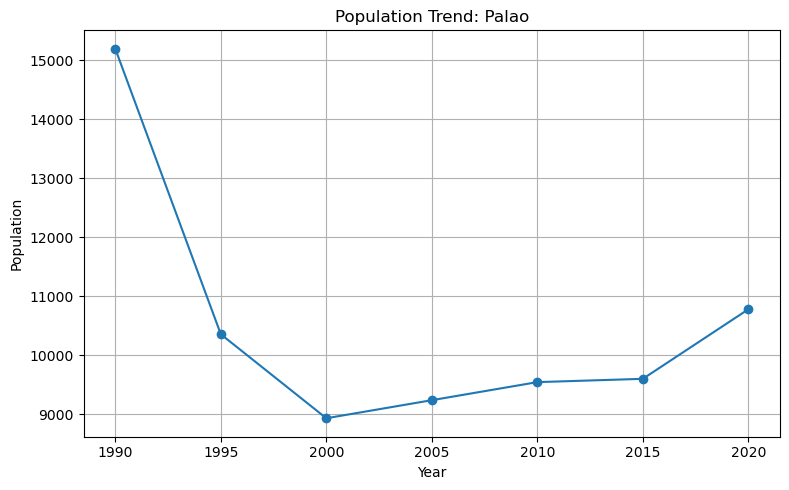

In [8]:
# --- Step 3: Plot trend for a sample barangay
sample_barangay = "Palao"

# Filter data for selected barangay
bgy_data = interpolated_df[interpolated_df["Barangay"] == sample_barangay]


# Sort just in case
bgy_data = bgy_data.sort_values("Year")

# Plot population trend
plt.figure(figsize=(8, 5))
plt.plot(bgy_data["Year"], bgy_data["Population"], marker="o", linestyle='-')
plt.title(f"Population Trend: {sample_barangay}")
plt.xlabel("Year")
plt.ylabel("Population")
plt.grid(True)
plt.tight_layout()
plt.show()



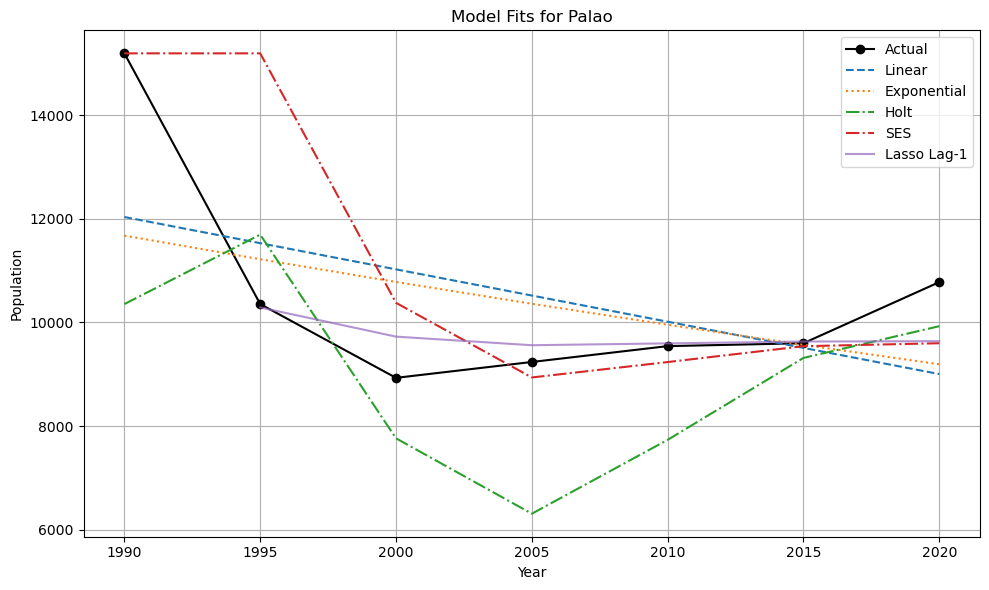

In [10]:
# --- Step 4: Fit Linear, Exponential, Holt, SES, and Lasso Lagged for a sample barangay

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import Holt, SimpleExpSmoothing

# Use the interpolated data
bgy_data = interpolated_df[interpolated_df["Barangay"] == sample_barangay].sort_values("Year")

# Drop missing population values just in case (should be none)
bgy_nonan = bgy_data.dropna(subset=["Population"])

# Prepare input features
X = bgy_nonan["Year"].values.reshape(-1, 1)
y = bgy_nonan["Population"].values

# --- Linear model
lin_model = LinearRegression().fit(X, y)
lin_pred = lin_model.predict(X)

# --- Exponential model (log-transform)
log_y = np.log(y)
exp_model = LinearRegression().fit(X, log_y)
exp_pred = np.exp(exp_model.predict(X))

# --- Holt’s Linear Trend
holt_model = Holt(y).fit()
holt_pred = holt_model.fittedvalues

# --- Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(y).fit()
ses_pred = ses_model.fittedvalues

# --- Lasso Lagged Regression (Lag-1)
X_lag = y[:-1].reshape(-1, 1)
y_lag = y[1:]
lasso_model = Lasso(alpha=0.1).fit(X_lag, y_lag)
lasso_pred = lasso_model.predict(X_lag)
lasso_pred_full = np.insert(lasso_pred, 0, np.nan)  # align with year axis

# --- Plot all fits
plt.figure(figsize=(10, 6))
plt.plot(bgy_nonan["Year"], y, marker="o", label="Actual", color="black")
plt.plot(bgy_nonan["Year"], lin_pred, label="Linear", linestyle='--')
plt.plot(bgy_nonan["Year"], exp_pred, label="Exponential", linestyle=':')
plt.plot(bgy_nonan["Year"], holt_pred, label="Holt", linestyle='-.')
plt.plot(bgy_nonan["Year"], ses_pred, label="SES", linestyle='dashdot')
plt.plot(bgy_nonan["Year"], lasso_pred_full, label="Lasso Lag-1", linestyle='solid', alpha=0.7)
plt.title(f"Model Fits for {sample_barangay}")
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [12]:
# --- Step 5: RMSE comparison and 2030 forecast
from sklearn.metrics import mean_squared_error

# Compute RMSEs
rmse_lin = np.sqrt(mean_squared_error(y, lin_pred))
rmse_exp = np.sqrt(mean_squared_error(y, exp_pred))
rmse_holt = np.sqrt(mean_squared_error(y, holt_pred))
rmse_ses = np.sqrt(mean_squared_error(y, ses_pred))
rmse_lasso = np.sqrt(mean_squared_error(y[1:], lasso_pred))  # lagged prediction skips first

# Store all RMSEs in a dictionary
rmse_dict = {
    "Linear": rmse_lin,
    "Exponential": rmse_exp,
    "Holt": rmse_holt,
    "SES": rmse_ses,
    "Lasso Lag-1": rmse_lasso
}

# Determine best model
best_model = min(rmse_dict, key=rmse_dict.get)
year_2030 = np.array([[2030]])

# Forecast 2030 using best model
if best_model == "Linear":
    forecast_2030 = lin_model.predict(year_2030)[0]
elif best_model == "Exponential":
    forecast_2030 = np.exp(exp_model.predict(year_2030)[0])
elif best_model == "Holt":
    forecast_2030 = holt_model.forecast(1)[0]
elif best_model == "SES":
    forecast_2030 = ses_model.forecast(1)[0]
elif best_model == "Lasso Lag-1":
    forecast_2030 = lasso_model.predict([[y[-1]]])[0]

# Print RMSEs and result
print("RMSE Comparison:")
for model, rmse in rmse_dict.items():
    print(f"{model:>17}: {rmse:.2f}")

print(f"\nBest model for {sample_barangay}: {best_model}")
print(f"Forecasted population in 2030: {forecast_2030:.0f}")



RMSE Comparison:
           Linear: 1721.24
      Exponential: 1710.00
             Holt: 2365.65
              SES: 1966.02
      Lasso Lag-1: 583.34

Best model for Palao: Lasso Lag-1
Forecasted population in 2030: 9776


# PERFORM to ALL 44 Barangays

In [12]:
# --- Step 6: Batch forecast for all barangays using 5 models

results = []

for bgy in interpolated_df["Barangay"].unique():
    bgy_data = interpolated_df[interpolated_df["Barangay"] == bgy].dropna()

    if len(bgy_data) < 3:
        continue

    X = bgy_data["Year"].values.reshape(-1, 1)
    y = bgy_data["Population"].values

    model_rmses = {}
    model_preds = {}

    # --- Linear
    lin_model = LinearRegression().fit(X, y)
    lin_pred = lin_model.predict(X)
    model_rmses["Linear"] = np.sqrt(mean_squared_error(y, lin_pred))
    model_preds["Linear"] = lin_model.predict([[2030]])[0]

    # --- Exponential
    try:
        log_y = np.log(y)
        exp_model = LinearRegression().fit(X, log_y)
        exp_pred = np.exp(exp_model.predict(X))
        model_rmses["Exponential"] = np.sqrt(mean_squared_error(y, exp_pred))
        model_preds["Exponential"] = np.exp(exp_model.predict([[2030]])[0])
    except:
        pass


    try:
        holt_model = Holt(y).fit()
        holt_pred = holt_model.fittedvalues
        model_rmses["Holt"] = np.sqrt(mean_squared_error(y, holt_pred))
        model_preds["Holt"] = holt_model.forecast(1)[0]
    except:
        pass

    # --- Simple Exponential Smoothing (SES)
    try:
        ses_model = SimpleExpSmoothing(y).fit()
        ses_pred = ses_model.fittedvalues
        model_rmses["SES"] = np.sqrt(mean_squared_error(y, ses_pred))
        model_preds["SES"] = ses_model.forecast(1)[0]
    except:
        pass


    if len(y) > 2:
        try:
            X_lag = y[:-1].reshape(-1, 1)
            y_lag = y[1:]
            lasso_model = Lasso(alpha=0.1).fit(X_lag, y_lag)
            lasso_pred = lasso_model.predict(X_lag)
            model_rmses["Lasso Lag-1"] = np.sqrt(mean_squared_error(y_lag, lasso_pred))
            model_preds["Lasso Lag-1"] = lasso_model.predict([[y[-1]]])[0]
        except:
            pass

    # --- Select best model based on RMSE
    best_model = min(model_rmses, key=model_rmses.get)
    best_rmse = model_rmses[best_model]
    forecast_2030 = model_preds[best_model]

    results.append({
        "Barangay": bgy,
        "Best_Model": best_model,
        "RMSE": round(best_rmse, 2),
        "Projected_2030": round(forecast_2030)
    })

# --- Final output
forecast_df = pd.DataFrame(results).sort_values("Barangay").reset_index(drop=True)




In [13]:
# --- Step 7: Save forecast table to CSV
forecast_df.to_csv("newforecast_output_2030.csv", index=False)

# Confirm saved
print(" Forecast saved to 'newforecast_output_2030.csv'")


 Forecast saved to 'newforecast_output_2030.csv'


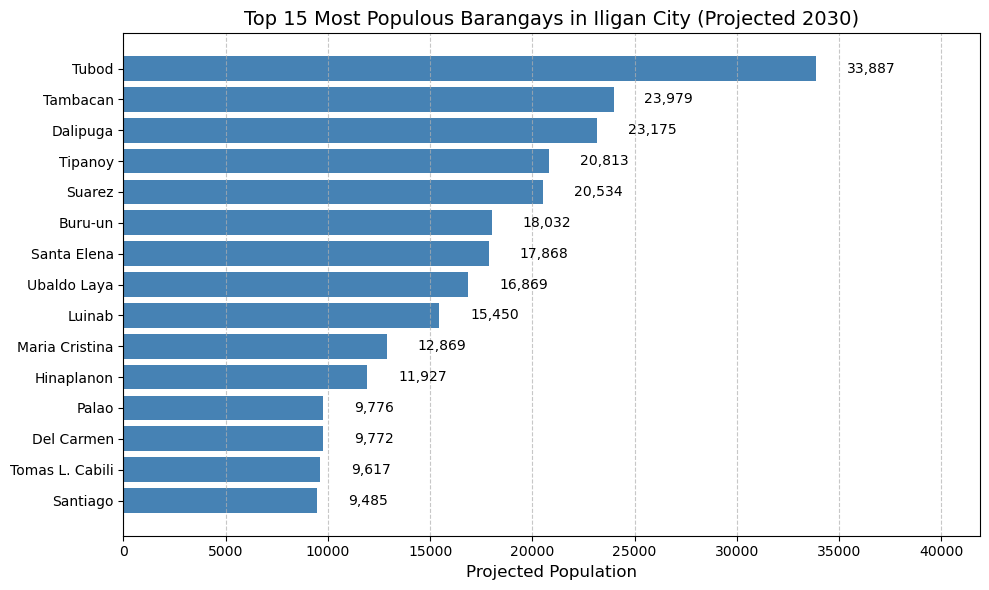

In [14]:
# --- Load saved forecast and plot top 15 with improved label spacing
import pandas as pd
import matplotlib.pyplot as plt

# Load the forecast results
forecast_df = pd.read_csv("newforecast_output_2030.csv")

# Sort by projected 2030 population and select top 15
top15 = forecast_df.sort_values("Projected_2030", ascending=False).head(15)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(top15["Barangay"], top15["Projected_2030"], color="#4682B4")

# Add labels with more space (offset increased to 1500)
for bar in bars:
    value = int(bar.get_width())
    plt.text(value + 1500, bar.get_y() + bar.get_height()/2,
             f"{value:,}", va='center', fontsize=10)

# Extend x-axis limit slightly beyond the max value
max_val = top15["Projected_2030"].max()
plt.xlim(0, max_val + 8000)

# Chart styling
plt.title("Top 15 Most Populous Barangays in Iligan City (Projected 2030)", fontsize=14)
plt.xlabel("Projected Population", fontsize=12)
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


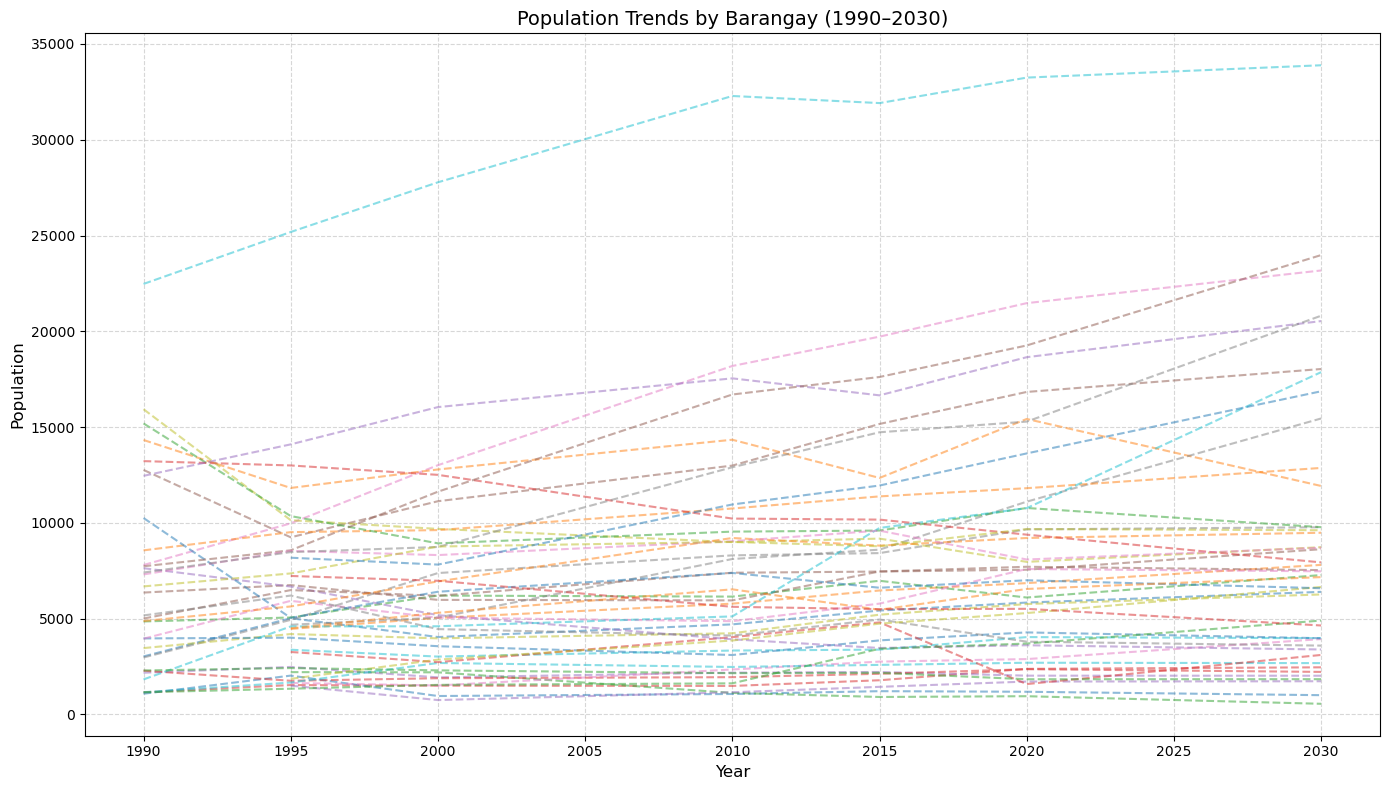

In [15]:
import matplotlib.pyplot as plt

# --- Step: Merge forecast with historical long-format data
pop_long = df_long.copy()  # Assumes df_long has: Barangay, Year, Population

# Prepare 2030 forecast in same format
pop_2030 = forecast_df[["Barangay", "Projected_2030"]].copy()
pop_2030["Year"] = 2030
pop_2030 = pop_2030.rename(columns={"Projected_2030": "Population"})

# Combine actual + forecasted population
full_data = pd.concat([pop_long, pop_2030], ignore_index=True)
full_data = full_data.sort_values(["Barangay", "Year"])

# --- Plot all barangay trends
plt.figure(figsize=(14, 8))

for bgy, group in full_data.groupby("Barangay"):
    group = group.sort_values("Year")
    years = group["Year"]
    values = group["Population"]

    # Line style: dashed if 2030 is included
    linestyle = "--" if 2030 in years.values else "-"
    plt.plot(years, values, linestyle=linestyle, alpha=0.5)

# Enhance the plot
plt.title("Population Trends by Barangay (1990–2030)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(np.arange(1990, 2035, 5))
plt.tight_layout()
plt.show()


##  Forecasting Discussion

This section summarizes and discusses the results of our barangay-level population forecasting for Iligan City, focusing on the projected population values for the year 2030.

###  Overview

Using historical census data from 1990 to 2020 (with linear interpolation for 2005), we applied a set of candidate forecasting models to each barangay:

- **Linear Growth**
- **Exponential Growth**
- **Lasso Lagged Regression (Lag-1)**

Each model was evaluated based on **Root Mean Squared Error (RMSE)** using only known historical values. The model with the lowest RMSE per barangay was selected and used to forecast the **2030 population**.

###  Model Selection Insights

- The most frequently selected model was **Lasso Lagged Regression**, particularly for barangays with recent fluctuations or non-linear growth behavior.
- **Linear Regression** remained strong for barangays with steady trends across decades.
- **Exponential Growth** was selected for barangays showing consistent multiplicative increases or recoveries after past declines.

###  Summary of Results

- **Tubod** is projected to have the **highest population in 2030** (~33,887), followed by **Tambacan** and **Dalipuga**.
- Several barangays such as **Palao**, **Kiwalan**, and **Santa Elena** are projected to cross key population thresholds, which has implications for service delivery and infrastructure planning.
- Barangays like **Bonbonon**, **Kalilangan**, and **Hindang** remain among the least populous, but may still require attention due to strategic location or geographic vulnerability.

###  Limitations

- Some models (e.g., Holt’s, SES) were excluded in the final stage due to sensitivity to missing data or irregularity in census intervals.
- Forecasts assume **no major external shocks** (e.g., disasters, mass migration), and follow the observed historical pattern.

###  Implications

The forecasting results are intended to support **evidence-based urban planning**, especially in:

- Fire and disaster response base planning
- Social services and school capacity planning
- Transport and infrastructure investment

These projections may be refined further with updated census data or enhanced using spatially-aware and AI-driven models.
   